# Решающие деревья

При подготовке использовались <a href="https://github.com/esokolov/ml-course-hse/blob/master/2017-fall/seminars/sem07-trees.ipynb">материалы</a> Евгения Соколова

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

# Постановка задачи и примеры


### Дерево для задачи классификации:
<img src='img/0_tree.png' Width=900>

### Дерево для задачи регрессии:

Сгенерируем датасет

In [2]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

Обучим модели

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [16]:
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = RandomForestRegressor(max_depth=10, n_estimators=1000, criterion='mae')
regr_1.fit(X, y)
regr_2.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=1000,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

Предскажем обученными регрессорами

In [17]:
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

Построим график

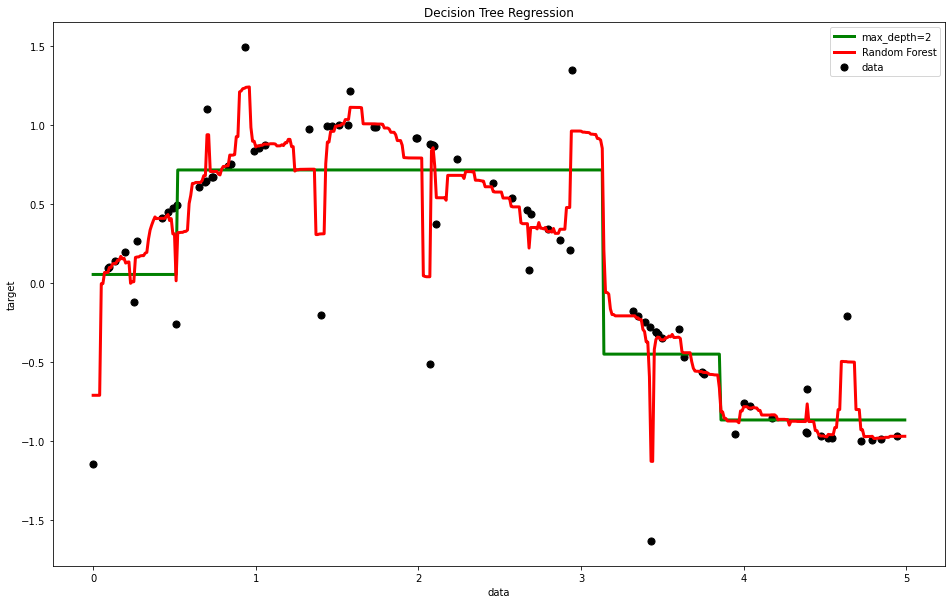

In [19]:
plt.figure(figsize=(16, 10))

plt.scatter(X, y, s=50, color="black", label="data")
plt.plot(X_test, y_1, color="green", label="max_depth=2", linewidth=3)
plt.plot(X_test, y_2, color="red", label="Random Forest", linewidth=3)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

## Красивая визуализация

http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

# Построение деревьев

* Обучающая выборка $(x_i,y_i)_{i=1}^l\in X \times Y$
* Как разбить на две части: $R_1(j,s)=\{x|x_j \leq s\}$ и $R_2(j,s) = \{x | x_j > s \}$ с использованием критерия Q(X, j, s)?

Найдём наилучшие значения $j$ и $s$, создадим корневую вершину дерева, поставив ей в соответствие функцию (предикат) $[x_j \leq s ]$. Объекты выборки будут разбиты на две части и попадут либо в левое, либо в правое поддерево. Продолжим эту процедуру для каждой подвыборки. Если после очередного разбиения в одной из половин окажутся объекты одного из классов, то создадим листовую вершину, которой будет соответствовать класс попавших в неё объектов.

Жадный алгоритм переусложняет структуру дерева:


<img src='img/0_greedy_tree.png' Width=900>

# Критерии информативности

* $R_m$ - множество объектов обучающей выборки, попавших в вершину $m$, 
* $N_m=|R_m|$.
* $p_{mk}$ - доля объектов класса $k\in\{1, ..., K\}$, попавших в вершину $m$: $p_{mk}=\frac{1}{N_m} \sum\limits_{x_i\in R_m} [y_i = k]$.
* $k_m = arg \max\limits_{k} p_{mk}$ - класс, чьих представителей больше всего среди объектов, попавших в вершину $m$.


## 1. Ошибка классификации

Если бы вершина $m$ была листовой и относила все объекты к классу $k$:

$$
H(R_m) = \frac{1}{N_m} \sum\limits_{x_i \in R_m} [y_i \neq k_m].
$$

Критерий информативности при ветвлении вершины $m$: ($l$ и $r$ - правые и левые вершины)

$$
Q(R_m, j, s) = H (R_m) - \frac{N_l}{N_m} H(R_l) - \frac{N_r}{N_m} H(R_r) \to \max\limits_{j, s}
$$

Грубый критерий - учитывает частоту $p_{m, k_m}$ лишь одного класса

#### Задача 1
Покажите, что ошибку классификации также можно записать в виде 
$$H(R_m) = 1 - p_{m, k_m}$$

#### Решение    
$$ 
1 = \frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m}[y_i \neq k_m] + \frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m}[y_i = k_m] 
$$
$$
H(R_m) = \frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m}[y_i \neq k_m] = 1 - p_{m, k_m}
$$

## 2. Индекс Джини
* Функционал имеет вид $$ H(R_m) = \sum\limits_{k \neq k'}p_{mk}p_{mk'}$$
* Аналогично определяется критерий информативности:
$$
Q(R_m, j, s) = H(R_m) - \frac{N_l}{N_m} H(R_l) - \frac{N_r}{N_m} H(R_r).
$$

#### Задача 2

Покажите, что индекс Джини $H(R_m)$ также можно записать в виде: 

$$H(R_m) = \sum_{k = 1}^{K} p_{mk} (1 - p_{mk}) = 1 - \sum_{k = 1}^K p_{mk}^2$$

#### Решение

$$
        \sum_{k \neq k'} p_{mk} p_{mk'}
        =
        \sum_{k = 1}^{K} p_{mk} \sum_{k' \neq k} p_{mk'}
        =
        \sum_{k = 1}^{K} p_{mk} (1 - p_{mk}).
$$

#### Задача 3

Рассмотрим вершину $m$ и объекты $R_m$, попавшие в нее. Сопоставим в соответствие вершине $m$ алгоритм $a(x)$, который выбирает класс случайно, причем класс $k$ выбирается с вероятностью $p_{mk}$. Покажите, что матожидание частоты ошибок этого алгоритма на объектах из $R_m$ равно индексу Джини.

#### Решение

\begin{multline*}
\mathbb E\frac{1}{N_m} \sum_{x_i \in R_m} [y_i \neq a(x_i)]
=
\frac{1}{N_m} \sum_{(x_i,\,y_i) \in R_m} \mathbb E[y_i \neq a(x_i)]
=
\frac{1}{N_m} \sum_{(x_i,\,y_i) \in R_m} (1 - p_{m,y_i})
=\\
=
\sum_{k = 1}^{K} \frac{\sum_{(x_i,\,y_i) \in R_m} [y_i = k]}{N_m} (1 - p_{mk})
=
\sum_{k = 1}^{K} p_{mk} (1 - p_{mk}).
\end{multline*}

Выясним теперь, какой смысл имеет максимизация функционала, соответствующего критерию информативности Джини.
Сразу выбросим из функционала $H(R_m)$, поскольку данная величина не зависит от $j$ и $s$.
Преобразуем критерий:

\begin{align*}
&- \frac{N_\ell}{N_m} H(R_\ell) - \frac{N_r}{N_m} H(R_r)=- \frac{1}{N_m} \left(
N_\ell - \sum_{k = 1}^{K} p_{\ell k}^2 N_\ell + N_r - \sum_{k = 1}^{K} p_{r k}^2 N_r \right)=\\
&=
\frac{1}{N_m} \left(\sum_{k = 1}^{K} p_{\ell k}^2 N_\ell +\sum_{k = 1}^{K} p_{r k}^2 N_r - N_m
\right)= \{\text{$N_m$ не зависит от $j$ и $s$}\} = \\
&=\sum_{k = 1}^{K} p_{\ell k}^2 N_\ell + \sum_{k = 1}^{K} p_{r k}^2 N_r.
\end{align*}

Запишем теперь в наших обозначениях число таких пар объектов $(x_i, x_j)$,
что оба объекта попадают в одно и то же поддерево, и при этом $y_i = y_j$.
Число объектов класса $k$, попавших в поддерево $\ell$,
равно $p_{\ell k} N_\ell$;
соответственно, число пар объектов с одинаковыми метками, попавших в левое
поддерево, равно $\sum_{k = 1}^{K} p_{\ell k}^2 N_\ell^2$.
Интересующая нас величина равна
$$
\sum_{k = 1}^{K} p_{\ell k}^2 N_\ell^2 + \sum_{k = 1}^{K} p_{r k}^2 N_r^2.
$$
Заметим, что данная величина очень похожа на полученное
выше представление для критерия Джини.
Таким образом, максимизацию функционала Джини можно <i>условно</i>
интерпретировать как максимизацию числа пар объектов одного класса,
оказавшихся в одном поддереве.

## 3. Энтропийный критерий (критерий Шеннона)
Рассмотрим дискретную случайную величину,
принимающую $K$ значений с вероятностями $p_1, \dots, p_K$
соответственно.
*** Энтропия *** этой случайной величины определяется как:
$$H(p) = -\sum_{k = 1}^{K} p_k \log_2 p_k$$

#### Задача 4
Покажите, что энтропия ограничена сверху и достигает своего максимума на
равномерном распределении $p_1 = \dots = p_K = 1/K$.

#### Решение

Нам понадобится неравенство Йенсена: для любой вогнутой функции $f$
выполнено
$$
    f\left(\sum_{i = 1}^{n} a_i x_i\right) \geq \sum_{i = 1}^{n} a_i f(x_i),
$$
если $\sum_{i = 1}^{n} a_i = 1$.

Применим его к логарифму в определении энтропии~(он является вогнутой функцией):
$$
H(p) = \sum_{k = 1}^{K} p_k \log_2 \frac{1}{p_k}
\leq \log_2 \left( \sum_{k = 1}^{K} p_i \frac{1}{p_i} \right)=\log_2 K.
$$

Наконец, найдем энтропию равномерного распределения:
$$
-\sum_{k = 1}^{K} \frac{1}{K} \log_2 \frac{1}{K} = - K \frac{1}{K} \log_2 \frac{1}{K} = \log_2 K.
$$ 

Энтропия ограничена снизу нулем, причем минимум достигается на вырожденных
распределениях ($p_i = 1$, $p_j = 0$ для $i \neq j$).

Энтропийный критерий информативности определяется как
$$
    Q(R_m, j, s) = H(p_m) - \frac{N_\ell}{N_m} H(p_\ell) - \frac{N_r}{N_m} H(p_r),
$$
где $p_i = (p_{i1}, \dots, p_{iK})$ - распределение классов в $i$-й вершине.
Видно, что данный критерий отдает предпочтение более "вырожденным" распределениям
классов.

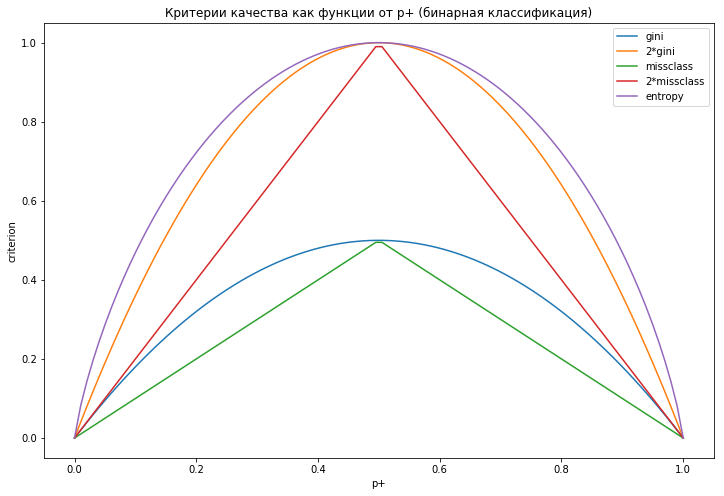

In [11]:
plt.figure(figsize=(12, 8))

p = np.linspace(0, 1, 100)

plt.plot(p, [2 * x * (1-x) for x in p], label='gini')
plt.plot(p, [4 * x * (1-x) for x in p], label='2*gini')
plt.plot(p, [1 - max(x, 1 - x) for x in p], label='missclass')
plt.plot(p, [2 * (1 - max(x, 1 - x)) for x in p], label='2*missclass')
plt.plot(p, [-x * np.log2(x + 1e-10) - (1 - x) * np.log2(1 - x + 1e-10) for x in p], label='entropy')

plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерии качества как функции от p+ (бинарная классификация)')
plt.legend()
plt.show()

# Пример: предсказание цвета шарика по его координате
<img src='img/0_entropy_statement.png' Width=1200>

* Вероятности вытаскивания синего и жёлтого шариков соответственно: $$ p_1 = \frac{9}{20}, p_2 = \frac{11}{20}$$
* Энтропия такого состояния: $$ S_0 = -\frac{9}{20} log_2 \frac{9}{20} - \frac{11}{20} log_2 \frac{11}{20} \approx 1$$

Как изменится энтропия, если разбить шарики на две группы?
<img src='img/0_entropy_first_split.png' Width=1200>

* Для первой группы: $$ S_1 = -\frac{8}{13} log_2 \frac{8}{13} - \frac{5}{13} log_2 \frac{5}{13} \approx 0,96 $$

* И для второй: $$ S_2 = -\frac{6}{7} log_2 \frac{6}{7} - \frac{1}{7} log_2 \frac{1}{7} \approx 0,6 $$

* Энтропия уменьшилась в обеих группах. 
* Мера прироста информации:
$$IG(Q) = S_0 - \sum\limits_{i=1}^q \frac{N_i}{N} S_i $$
где q - число групп после разбиения, $N_i$ - число элементов выборки, у которых признак $Q$ имеет $i$-е значение.
* $$IG(x\leq 12) = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16$$

<img src='img/0_entropy_split.png' Width=800>

* Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($log_2 ⁡1=0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная.

## 4. Критерии в задачах регрессии
В задачах регрессии, как правило, в качестве критерия выбирают дисперсию ответов в листе:
$$
H_R(R_m) = \frac{1}{N_m} \sum_{(x_i,\,y_i) \in R_m} \left(y_i-\frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m} y_j \right)^2.
$$
Можно использовать и другие критерии - например, среднее абсолютное отклонение от медианы.

# Критерий останова построения дерева

Для любой непротиворечивой обучающей выборки можно построить решающее дерево, которое имеет нулевую ошибку на данной выборке. Если мы рассмотрим объекты, как точки в пространстве признаков, то каждую эту точку можно ограничить n-мерным кубиком, который не будет содержать других точек. n-мерный кубик прекрасно можно задать деревом.

 Однако в этом случае имеет место **переобучение**. 

В связи с этим встаёт вопрос: в каком случае вершину следует объявить листовой?

Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевой переменной — расстояние от объекта до точки (0, 0).

In [20]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01),
    )

Сгенерируем датасет

In [21]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5

Визуализируем

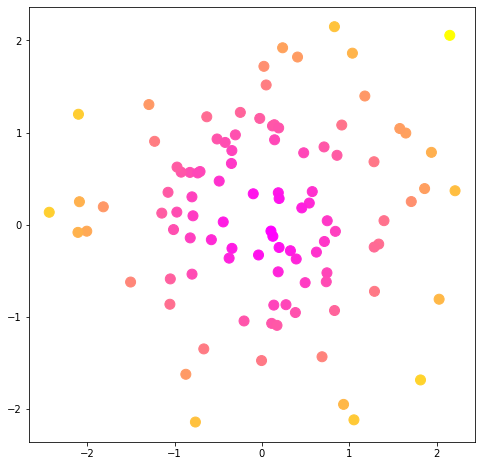

In [22]:
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

Обучим регрессор

In [27]:
clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

Посмотрим как выглядят предсказания

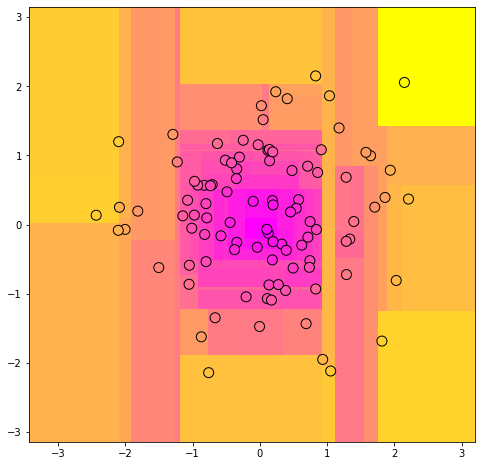

In [28]:
xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

Посмотрим как будет выглядить разделение плоскости в зависимости от 
- минимального количества объектов в листе
- максимальной глубины дерева

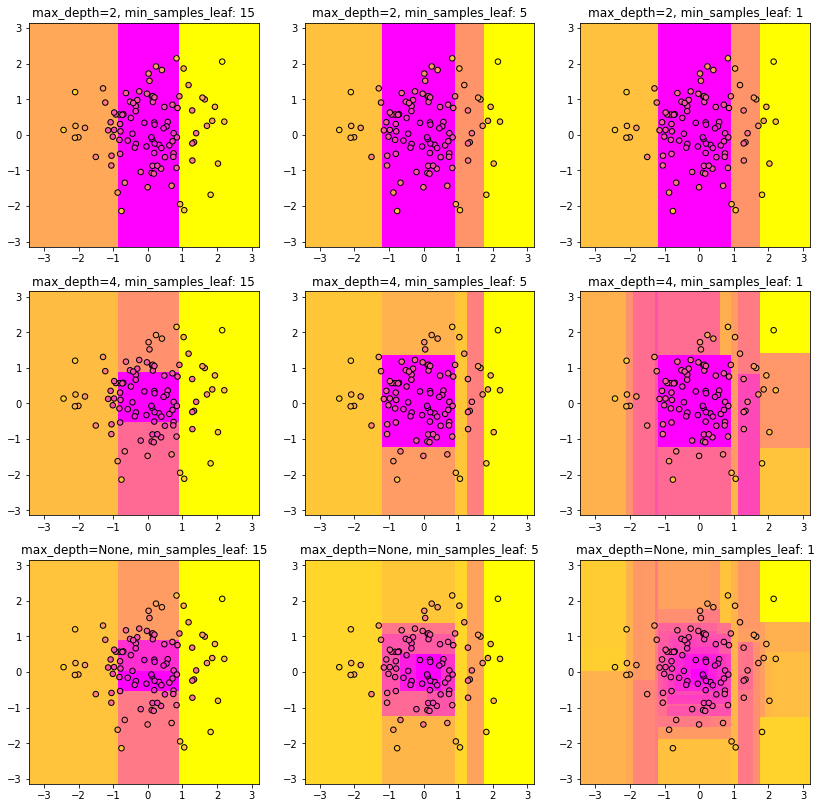

In [29]:
plt.figure(figsize=(14, 14))

for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

- Увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе приводит к увеличению качества на обучающей выборке и переобучению.

## Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться.
Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.


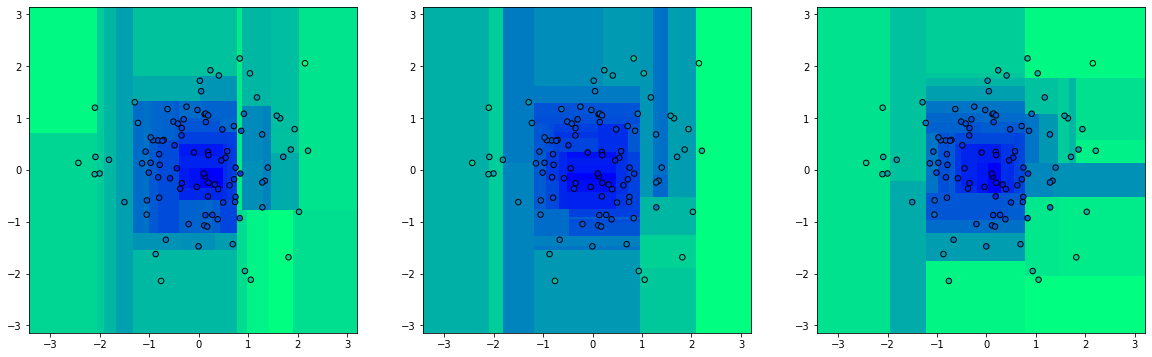

In [30]:
plt.figure(figsize=(20, 6))

for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

### Категориальные признаки в деревьях

Есть несколько подходов работы с категориальными признаками в деревьях:

* One-hot encoding, Mean target encoding, binary encoding
* В некоторых фрэймворках (CatBoost) количество исходящих ребер в вершине может быть равно не 2, а количеству категориальных признаком. Таким образом естественно будут учитываться категориальные признаки.

# Преимущества и Недостатки решающих деревьев:

**Преимущества**
 * хорошо интерпретируются
 * легко обобщаются для регрессии и классификации
 * допускаются разнотипные данные
 
**Недостатки**
 * Сравнение с линейными алгоритмами на линейно разделимой выборке - фиаско
 * Переобучение
 * Неустойчивость к шуму, составу выборки, критерию
 
**Способы устранения недостатков**
 * прунинг (усечение)
 * композиции (леса) деревьев

#### Pruning

Есть разные подходы к прунингу. Самый простой: срезаем листья и делаем родительскую вершину листом с ответом равным самому частому классу, смотрим на изменение качества на выборке, останавливаем, когда оно начинает ухудшаться. 
Или же мы можем находить поддерево, удаление которого не ухудшит нашу ошибку на валидационной выборке, как показано на рисунке:

<img src='img/pruning.png' Width=800>